In [1]:
import warnings
warnings.filterwarnings('ignore')

# Packages

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, kruskal, iqr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Business and Data Understanding

## Business interest

The used car market in India is a dynamic and ever-changing landscape. Prices can fluctuate wildly based on a variety of factors.

The dataset can be used by car dealership business, which helps to sell and buy used cars.

### Business Objective

 - In order to have a high commission from the sold cars, business is interested in selling cars for **a high prices**.
 - Additionally business is interested in **a big amount of deals** which increases overall profit.

### Business Constraint

However if you will be selling cars for unreasonably **high prices** you will get horrible reputation which affects **the amounts of deals**.

### Success Criteria

Satisfactory criteria from buyers and sellers of cars. The priority is given with respect to the context (e.g. we have a lot of sellers and very few buyers)

**ML Success Criteria**: Get small RMSE

## Exploratory Data Analysis (EDA)

### Data Collection

In [3]:
cars = pd.read_csv("https://raw.githubusercontent.com/DIG-Placements/Datasets/main/Car%20Dataset.csv")

- This data is collected from 'Car Dekho'.
- Secondary Data Source

Following details of cars are included in the dataset:

1) Car name
2) Year
3) Selling Price
4) Kms driven
5) Fuel
6) Seller type
7) Transmission
8) Owner

### Data Analysis

In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


- Structured Data
- Cross-Sectional Data

Variable of interest is **price**.

In [10]:
target = ['selling_price']
continuousFeatures = ['km_driven', 'year']

nominalFeatures = ['name', 'fuel', 'transmission', 'seller_type']
ordinalFeatures = ['owner']

In [7]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [8]:
cars.shape

(4340, 8)

# 2. Data Preparation

## Feature engineering 1

We have too much unique values in presumably categorical column

In [4]:
cars.name.nunique()

1491

Therefore we can Extract the first word of the `name` column, which most probably will be brand of the car that affects `selling_price`.

In [4]:
cars['brand'] = cars.name.str.split().str[0]

After that we can drop `name` column to avoid overfitting.

In [5]:
cars.drop('name', axis=1, inplace=True)
cars.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti


In [10]:
cars.brand.nunique()

29

In [21]:
cars.brand.value_counts().value_counts()

count
1       4
2       2
4       2
6       2
37      2
821     1
3       1
5       1
35      1
39      1
60      1
1280    1
68      1
107     1
146     1
188     1
206     1
238     1
252     1
361     1
365     1
64      1
Name: count, dtype: int64

In [27]:
len(cars.brand.value_counts())

29

In [33]:
cars.brand.value_counts()[cars.brand.value_counts()<=100].count()

19

In [6]:
otherBrands = list(cars.brand.value_counts()[cars.brand.value_counts()<=100].index)
otherBrands

['Skoda',
 'Nissan',
 'Audi',
 'BMW',
 'Fiat',
 'Datsun',
 'Mercedes-Benz',
 'Jaguar',
 'Mitsubishi',
 'Land',
 'Volvo',
 'Ambassador',
 'Jeep',
 'MG',
 'OpelCorsa',
 'Daewoo',
 'Force',
 'Isuzu',
 'Kia']

In [7]:
cars.loc[cars.brand.isin(otherBrands), 'brand'] = 'other'

In [8]:
cars.brand.value_counts()

brand
Maruti        1280
Hyundai        821
other          376
Mahindra       365
Tata           361
Honda          252
Ford           238
Toyota         206
Chevrolet      188
Renault        146
Volkswagen     107
Name: count, dtype: int64

## Exploratory Data Analysis (EDA) 1

### First Moment Business Decision

#### Overall

In [11]:
cars[continuousFeatures].agg(['mean', 'median'])

,km_driven,year
mean,66215.777419,2013.090783
median,60000.000000,2014.000000


- `km_driven` is right skewed
- `year` is slightly left skewed

In [12]:
cars.selling_price.agg(['mean', 'median'])

mean      504127.311751
median    350000.000000
Name: selling_price, dtype: float64

The target variable is right skewed.

In [82]:
cars[ordinalFeatures+nominalFeatures].mode()

,owner,brand,fuel,transmission,seller_type
0,First Owner,Maruti,Diesel,Manual,Individual


In [13]:
cars.owner.value_counts()

owner
First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: count, dtype: int64

In [14]:
cars.brand.value_counts()[:2]

brand
Maruti     1280
Hyundai     821
Name: count, dtype: int64

In [15]:
cars.fuel.value_counts()

fuel
Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: count, dtype: int64

In [16]:
cars.transmission.value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

We have unimodal categorical variables

**Overall Conclusions:**

- `km_driven` is right skewed
- `year` is slightly left skewed
- the target (`selling_price`) variable is right skewed
- unimodal categorical variables

#### By `owner`

In [18]:
cars[continuousFeatures+['owner']].groupby('owner').agg(['mean', 'median'])

km_driven                  year        
                              mean   median         mean  median
owner                                                           
First Owner           56015.009887  50000.0  2014.440678  2015.0
Fourth & Above Owner  99138.135802  90000.0  2007.395062  2008.0
Second Owner          81783.518987  80000.0  2010.983725  2012.0
Test Drive Car         4155.000000   1010.0  2019.529412  2020.0
Third Owner           99304.506579  90000.0  2009.338816  2010.0

- `km_driven` is positively correlated with `owner`
- `year` is negatively correlated with `owner`

In [19]:
cars[['owner', 'selling_price']].groupby('owner').agg(['mean', 'median'])

selling_price          
                               mean    median
owner                                        
First Owner           598636.969633  450000.0
Fourth & Above Owner  173901.197531  130000.0
Second Owner          343891.088608  250499.5
Test Drive Car        954293.941176  894999.0
Third Owner           269474.003289  190000.0

The `owner` fields seemas like affects the target variably significantly

In [20]:
owners = ['Test Drive Car', 'First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner']
groups = [cars[cars['owner'] == owner]['selling_price'] for owner in owners]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

7.938684216471109e-54


By analyzing the data with ANOVA, you've taken an important step in comparing the effect of different owners. Assuming an alpha of 0.05, the P-value indicates significant differences in owner groups.

In [20]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['owner'], 
    alpha=.05
)

print(tukey_results)

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
       group1               group2          meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------------------------------
         First Owner Fourth & Above Owner -424735.7721    0.0  -597590.0917 -251881.4525   True
         First Owner         Second Owner  -254745.881    0.0  -309135.0967 -200356.6653   True
         First Owner       Test Drive Car  355656.9715 0.0703   -17485.1427  728799.0858  False
         First Owner          Third Owner -329162.9663    0.0  -421740.1019 -236585.8308   True
Fourth & Above Owner         Second Owner  169989.8911 0.0657    -6575.0261  346554.8083  False
Fourth & Above Owner       Test Drive Car  780392.7436    0.0   371183.7254 1189601.7619   True
Fourth & Above Owner          Third Owner   95572.8058 0.6535   -96227.8961  287373.5076  False
        Second Owner       Test Drive Ca

In [93]:
cars[nominalFeatures+['owner']].groupby('owner').agg(pd.Series.mode)

,brand,fuel,transmission,seller_type
owner,,,,
First Owner,Maruti,Diesel,Manual,Individual
Fourth & Above Owner,Maruti,Petrol,Manual,Individual
Second Owner,Maruti,Diesel,Manual,Individual
Test Drive Car,Ford,Petrol,Manual,Dealer
Third Owner,Maruti,Diesel,Manual,Individual


In [97]:
cars.owner.value_counts()

owner
First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: count, dtype: int64

**Overall Conclusions:**

- `km_driven` is positively correlated with `owner`
- `year` is negatively correlated with `owner`
- the target variable (`selling_price`) is noticeably negatively correlated with `owner`
- we can order `owner` by 

    * Test Drive Car -> 0
    * First Owner -> 1
    * Second Owner -> 2
    * Third Owner -> 3
    * Fourth & Above Owner -> 4

## Feature Engineering 2

With natural intuition and also results of Tukey's HSD test we can assume order on categorical `owner` field.

In [21]:
ownerDict = {
    'First Owner': 1, 
    'Second Owner': 2, 
    'Fourth & Above Owner': 4,
    'Third Owner': 3, 
    'Test Drive Car': 0
}
cars['owner'] = cars.owner.map(lambda x: ownerDict[x])

cars.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,Petrol,Individual,Manual,1,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,1,Maruti


In [12]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['owner'], 
    alpha=.05
)

print(tukey_results)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
     0      1 -355656.9715 0.0703  -728799.0858   17485.1427  False
     0      2 -610402.8526 0.0001  -985278.2874 -235527.4178   True
     0      3 -684819.9379    0.0 -1067107.6971 -302532.1787   True
     0      4 -780392.7436    0.0 -1189601.7619 -371183.7254   True
     1      2  -254745.881    0.0  -309135.0967 -200356.6653   True
     1      3 -329162.9663    0.0  -421740.1019 -236585.8308   True
     1      4 -424735.7721    0.0  -597590.0917 -251881.4525   True
     2      3  -74417.0853  0.245  -173750.2632   24916.0925  False
     2      4 -169989.8911 0.0657  -346554.8083    6575.0261  False
     3      4  -95572.8058 0.6535  -287373.5076   96227.8961  False
-------------------------------------------------------------------


In [27]:
nominalFeatures = ['brand', 'fuel', 'seller_type', 'transmission']

## Exploratory Data Analysis (EDA) 2

### First Moment Business Decision

#### By `seller_type`

In [28]:
cars[continuousFeatures+['seller_type']].groupby('seller_type').agg(['mean', 'median'])

km_driven                  year        
                          mean   median         mean  median
seller_type                                                 
Dealer            52827.259557  49000.0  2014.200201  2015.0
Individual        71167.556104  70000.0  2012.665228  2013.0
Trustmark Dealer  39202.215686  46507.0  2015.813725  2016.0

In [29]:
cars[['seller_type', 'selling_price']].groupby('seller_type').agg(['mean', 'median'])

selling_price          
                           mean    median
seller_type                              
Dealer            721822.890342  495000.0
Individual        424505.419236  300000.0
Trustmark Dealer  914950.980392  750000.0

Cars are more expensive in Trustmark Dealer and Dealer than Individual

In [31]:
cars[nominalFeatures].groupby('seller_type').agg(pd.Series.mode)

,brand,fuel,transmission
seller_type,,,
Dealer,Hyundai,Diesel,Manual
Individual,Maruti,Petrol,Manual
Trustmark Dealer,Maruti,Petrol,Manual


In [32]:
cars.seller_type.value_counts()

seller_type
Individual          3244
Dealer               994
Trustmark Dealer     102
Name: count, dtype: int64

In [33]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['seller_type'], 
    alpha=.05
)

print(tukey_results)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
  group1        group2        meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------
    Dealer       Individual -297317.4711    0.0 -345044.0629 -249590.8794   True
    Dealer Trustmark Dealer  193128.0901 0.0027   56252.6402  330003.5399   True
Individual Trustmark Dealer  490445.5612    0.0  358061.4024  622829.7199   True
--------------------------------------------------------------------------------


In [34]:
print(kruskal(cars[cars.seller_type=='Individual'].selling_price,
              cars[cars.seller_type=='Dealer'].selling_price,
              cars[cars.seller_type=='Trustmark Dealer'].selling_price))

KruskalResult(statistic=376.90124621472205, pvalue=1.4352722007408467e-82)


**Overall Conclusions**

- Cars are more expensive in Trustmark Dealer and Dealer than Individual
- It suggests that we can order also `seller_type`:
    * Individual -> 0
    * Dealer -> 1
    * Trustmark Dealer -> 2

In [35]:
cars.seller_type.value_counts()

seller_type
Individual          3244
Dealer               994
Trustmark Dealer     102
Name: count, dtype: int64

#### By `transmission`

In [37]:
cars[continuousFeatures+ordinalFeatures+['transmission']].groupby('transmission').agg(['mean', 'median'])

km_driven                  year             owner       
                      mean   median         mean  median      mean median
transmission                                                             
Automatic     49688.803571  41210.0  2014.877232  2016.0  1.272321    1.0
Manual        68118.162898  60000.0  2012.885149  2013.0  1.467112    1.0

Automatic cars drive more `km_driven` than Manual

In [38]:
cars[['transmission', 'selling_price']].groupby('transmission').agg(['mean', 'median'])

selling_price          
                      mean    median
transmission                        
Automatic     1.408154e+06  950000.0
Manual        4.000667e+05  325000.0

In [39]:
cars[nominalFeatures].groupby('transmission').agg(pd.Series.mode)

,brand,fuel,seller_type
transmission,,,
Automatic,other,Diesel,Dealer
Manual,Maruti,Petrol,Individual


In [40]:
print(ttest_ind(cars[cars.transmission=='Automatic'].selling_price, cars[cars.transmission=='Manual'].selling_price))

TtestResult(statistic=41.186960999151225, pvalue=0.0, df=4338.0)


In [41]:
print(mannwhitneyu(cars[cars.transmission=='Automatic'].selling_price, cars[cars.transmission=='Manual'].selling_price))

MannwhitneyuResult(statistic=1451609.0, pvalue=6.04367828645156e-118)


In [42]:
cars.transmission.value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

**Overall Conclusions**

- Automatic cars drive more `km_driven` than Manual
- Automatic cars are about 3 times more expensive than Manual

## Feature Engineering 3

With natural intuition and also results of Tukey's HSD test we can assume order on categorical `seller_type` field.

In [43]:
sellerDict = {
    'Individual': 0, 
    'Dealer': 1, 
    'Trustmark Dealer': 2,
}
cars['seller_type'] = cars.seller_type.map(lambda x: sellerDict[x])

cars.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,Petrol,0,Manual,1,Maruti
1,2007,135000,50000,Petrol,0,Manual,1,Maruti


In [44]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['seller_type'], 
    alpha=.05
)

print(tukey_results)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     0      1 297317.4711    0.0 249590.8794 345044.0629   True
     0      2 490445.5612    0.0 358061.4024 622829.7199   True
     1      2 193128.0901 0.0027  56252.6402 330003.5399   True
---------------------------------------------------------------


Since `transmission` is field with just two values:

In [45]:
cars.transmission.value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

we can inpose the order on this field:

In [46]:
transmissionDict = {
    'Manual': 0, 
    'Automatic': 1
}
cars['transmission'] = cars.transmission.map(lambda x: transmissionDict[x])

cars.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,Petrol,0,0,1,Maruti
1,2007,135000,50000,Petrol,0,0,1,Maruti


In [47]:
print(ttest_ind(cars[cars.transmission==1].selling_price, cars[cars.transmission==0].selling_price))

TtestResult(statistic=41.186960999151225, pvalue=0.0, df=4338.0)


In [48]:
print(mannwhitneyu(cars[cars.transmission==1].selling_price, cars[cars.transmission==0].selling_price))

MannwhitneyuResult(statistic=1451609.0, pvalue=6.04367828645156e-118)


In [49]:
target = ['selling_price']
continuousFeatures = ['km_driven', 'year']

nominalFeatures = ['brand', 'fuel']
ordinalFeatures = ['owner', 'seller_type', 'transmission']

## Exploratory Data Analysis (EDA) 3

### First Moment Business Decision

#### By `fuel`

In [50]:
cars[continuousFeatures+ordinalFeatures+['fuel']].groupby('fuel').agg(['mean', 'median'])

km_driven                  year             owner         \
                  mean   median         mean  median      mean median   
fuel                                                                    
CNG       67234.750000  71500.0  2013.475000  2013.0  1.675000    1.0   
Diesel    79630.977706  72000.0  2013.606595  2014.0  1.445425    1.0   
Electric  62000.000000  62000.0  2006.000000  2006.0  2.000000    2.0   
LPG       89634.782609  90000.0  2010.130435  2011.0  1.739130    2.0   
Petrol    52340.079604  50000.0  2012.595855  2014.0  1.440886    1.0   

         seller_type        transmission         
                mean median         mean median  
fuel                                             
CNG         0.225000    0.0     0.000000    0.0  
Diesel      0.290293    0.0     0.117975    0.0  
Electric    1.000000    1.0     1.000000    1.0  
LPG         0.043478    0.0     0.000000    0.0  
Petrol      0.264720    0.0     0.090909    0.0

In [51]:
cars[['fuel', 'selling_price']].groupby('fuel').agg(['mean', 'median'])

selling_price          
                   mean    median
fuel                             
CNG       277174.925000  247500.0
Diesel    669094.252206  500000.0
Electric  310000.000000  310000.0
LPG       167826.043478  180000.0
Petrol    344840.137541  269000.0

Diesel is most expensive while LPG is cheapest

In [52]:
fuels = ['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol']
groups = [cars[cars['fuel'] == fuel]['selling_price'] for fuel in fuels]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

1.1807188535653519e-77


In [53]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['fuel'], 
    alpha=.05
)

print(tukey_results)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
 group1   group2    meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------
     CNG   Diesel  391919.3272 0.0001   150242.3801  633596.2743   True
     CNG Electric    32825.075    1.0 -1500484.5209 1566134.6709  False
     CNG      LPG -109348.8815 0.9438  -505667.3235  286969.5605  False
     CNG   Petrol   67665.2125 0.9409  -174042.8782  309373.3033  False
  Diesel Electric -359094.2522 0.9673 -1873941.1975 1155752.6931  False
  Diesel      LPG -501268.2087 0.0002  -818744.5989 -183791.8186   True
  Diesel   Petrol -324254.1147    0.0  -370576.3765 -277931.8528   True
Electric      LPG -142173.9565 0.9991 -1689242.7425 1404894.8294  False
Electric   Petrol   34840.1375    1.0 -1480011.7767 1549692.0518  False
     LPG   Petrol  177014.0941 0.5485  -140486.0046  494514.1928  False
----------------------------------------------------------------

Diesel fuel have most distinctive affect on the price of the car.

In [55]:
cars[nominalFeatures+ordinalFeatures].groupby('fuel').agg(pd.Series.mode)

,brand,owner,seller_type,transmission
fuel,,,,
CNG,Maruti,1,0,0
Diesel,Maruti,1,0,0
Electric,Toyota,2,1,1
LPG,Maruti,"[1, 2]",0,0
Petrol,Maruti,1,0,0


In [56]:
cars.fuel.value_counts()

fuel
Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: count, dtype: int64

**Overall Conclusions**

- Diesel is most expensive while LPG is cheapest
- Diesel fuel have most distinctive affect on the price of the car.
- We don't have much representatives in Electric cars

#### By `brand`

In [20]:
cars[continuousFeatures+ordinalFeatures+['brand']].groupby('brand').agg(['mean', 'median'])

km_driven                  year             owner         \
                     mean   median         mean  median      mean median   
brand                                                                      
Chevrolet    72217.218085  68259.5  2012.090426  2012.0  1.494681    1.0   
Ford         65041.399160  60000.0  2013.861345  2014.0  1.420168    1.0   
Honda        57080.805556  50000.0  2013.853175  2015.0  1.273810    1.0   
Hyundai      55767.695493  52600.0  2013.293544  2014.0  1.400731    1.0   
Mahindra     83098.309589  70000.0  2013.391781  2014.0  1.504110    1.0   
Maruti       63264.387500  60000.0  2012.508594  2014.0  1.503906    1.0   
Renault      47421.287671  40000.0  2015.410959  2016.0  1.239726    1.0   
Tata         75933.714681  77073.0  2012.385042  2012.0  1.520776    1.0   
Toyota      100396.014563  80000.0  2013.082524  2013.0  1.524272    1.0   
Volkswagen   74776.112150  70000.0  2013.327103  2013.0  1.429907    1.0   
other        63358.090426  53000.0  2013.553191  2013.0  1.380319    1.0   

           seller_type        transmission         
                  mean median         mean median  
brand                                              
Chevrolet     0.191489    0.0     0.026596    0.0  
Ford          0.441176    0.0     0.079832    0.0  
Honda         0.468254    0.0     0.103175    0.0  
Hyundai       0.292326    0.0     0.093788    0.0  
Mahindra      0.142466    0.0     0.060274    0.0  
Maruti        0.244531    0.0     0.040625    0.0  
Renault       0.301370    0.0     0.041096    0.0  
Tata          0.083102    0.0     0.019391    0.0  
Toyota        0.330097    0.0     0.169903    0.0  
Volkswagen    0.373832    0.0     0.196262    0.0  
other         0.404255    0.0     0.473404    0.0

In [21]:
cars[['brand', 'selling_price']].groupby('brand').agg(['mean', 'median'])

selling_price          
                    mean    median
brand                             
Chevrolet   2.367271e+05  200000.0
Ford        5.712731e+05  500000.0
Honda       5.381468e+05  495000.0
Hyundai     4.199403e+05  350000.0
Mahindra    5.877095e+05  550000.0
Maruti      3.424163e+05  280500.0
Renault     4.193767e+05  380000.0
Tata        2.840834e+05  198000.0
Toyota      9.243592e+05  672500.0
Volkswagen  4.710373e+05  400000.0
other       1.249074e+06  620000.0

In [57]:
brands = list(cars.brand.unique())
groups = [cars[cars['brand'] == brand]['selling_price'] for brand in brands]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

1.2628102713554688e-225


Overall brand has affect on the price.

In [21]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['brand'], 
    alpha=.05
)

print(tukey_results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
  group1     group2     meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------
 Chevrolet       Ford  334546.0076    0.0  173860.1826  495231.8325   True
 Chevrolet      Honda  301419.7179    0.0  142715.9223  460123.5135   True
 Chevrolet    Hyundai  183213.1968 0.0005    50065.012  316361.3817   True
 Chevrolet   Mahindra  350982.4786    0.0    203147.44  498817.5173   True
 Chevrolet     Maruti  105689.2315 0.2254  -22933.9622  234312.4251  False
 Chevrolet    Renault   182649.628 0.0474     990.1544  364309.1015   True
 Chevrolet       Tata   47356.3074 0.9947 -100756.9104  195469.5251  False
 Chevrolet     Toyota  687632.1012    0.0  521529.7628  853734.4396   True
 Chevrolet Volkswagen   234310.282 0.0073   34884.9311  433735.6329   True
 Chevrolet      other  1012347.383    0.0  865249.3466 1159445.4193   True
      Ford      Honda  -3

In [58]:
cars[nominalFeatures+ordinalFeatures].groupby('brand').agg(pd.Series.mode)

,fuel,owner,seller_type,transmission
brand,,,,
Chevrolet,Diesel,1,0,0
Ford,Diesel,1,0,0
Honda,Petrol,1,0,0
Hyundai,Petrol,1,0,0
Mahindra,Diesel,1,0,0
Maruti,Petrol,1,0,0
Renault,Diesel,1,0,0
Tata,Diesel,1,0,0
Toyota,Diesel,1,0,0


### Second Moment Business Decision

#### Overall

In [23]:
cars[continuousFeatures+ordinalFeatures].agg(['var', 'std'])

,km_driven,year,owner,seller_type,transmission
var,2.175672e+09,17.769125,0.507216,0.246902,0.092592
std,4.664410e+04,4.215344,0.712191,0.496892,0.304289


In [24]:
cars[continuousFeatures+ordinalFeatures].agg(iqr)

km_driven       55000.0
year                5.0
owner               1.0
seller_type         1.0
transmission        0.0
dtype: float64

In [25]:
cars.selling_price.agg(['var', 'std'])

var    3.347186e+11
std    5.785487e+05
Name: selling_price, dtype: float64

In [26]:
iqr(cars.selling_price)

391250.25

In [27]:
cars[continuousFeatures+ordinalFeatures].max()-cars[continuousFeatures+ordinalFeatures].min()

km_driven       806598
year                28
owner                4
seller_type          2
transmission         1
dtype: int64

In [28]:
cars.selling_price.max()-cars.selling_price.min()

8880000

#### By `owner`

In [29]:
cars[continuousFeatures+ordinalFeatures].groupby('owner').agg(['var', 'std'])

km_driven                     year           seller_type            \
                var           std        var       std         var       std   
owner                                                                          
0      4.463669e+07   6681.069245   0.764706  0.874475    0.000000  0.000000   
1      1.995502e+09  44671.039222  12.808207  3.578856    0.301688  0.549261   
2      1.678765e+09  40972.733605  14.964441  3.868390    0.111059  0.333254   
3      2.464867e+09  49647.423503  15.472284  3.933482    0.028824  0.169775   
4      1.744169e+09  41763.246096  24.016975  4.900712    0.024383  0.156150   

      transmission            
               var       std  
owner                         
0         0.058824  0.242536  
1         0.108086  0.328764  
2         0.063271  0.251537  
3         0.064519  0.254006  
4         0.024383  0.156150

In [30]:
cars[continuousFeatures+ordinalFeatures].groupby('owner').agg(iqr)

,km_driven,year,seller_type,transmission
owner,,,,
0,4156.0,1.0,0.0,0.0
1,45590.0,5.0,1.0,0.0
2,44682.5,5.0,0.0,0.0
3,50000.0,5.0,0.0,0.0
4,31000.0,6.0,0.0,0.0


In [31]:
cars[['selling_price', 'owner']].groupby('owner').agg(['var', 'std'])

selling_price               
                var            std
owner                             
0      6.268639e+10  250372.495392
1      4.283688e+11  654498.859864
2      1.197011e+11  345978.403152
3      7.384610e+10  271746.389278
4      1.592954e+10  126212.276705

In [32]:
cars[['selling_price', 'owner']].groupby('owner').agg(iqr)

,selling_price
owner,
0,335000.0
1,425000.0
2,280000.0
3,210001.0
4,145000.0


In [33]:
cars[continuousFeatures+ordinalFeatures].groupby('owner').max()\
.add(-cars[continuousFeatures+ordinalFeatures].groupby('owner').min())

,km_driven,year,seller_type,transmission
owner,,,,
0,24484,3,0,1
1,805599,24,2,1
2,349999,24,2,1
3,385000,22,1,1
4,244144,28,1,1


In [34]:
cars[['selling_price', 'owner']].groupby('owner').max()\
.add(-cars[['selling_price', 'owner']].groupby('owner').min())

,selling_price
owner,
0,809000
1,8860000
2,4380000
3,2278000
4,660000


#### By `seller_type`

In [ ]:
cars[continuousFeatures+ordinalFeatures].groupby('seller_type').agg(['var', 'std'])

In [ ]:
cars[['seller_type', 'selling_price']].groupby('seller_type').agg(['var', 'std'])

In [ ]:
cars[continuousFeatures+ordinalFeatures].groupby('seller_type').agg(iqr)

In [ ]:
cars[['seller_type', 'selling_price']].groupby('seller_type').agg(iqr)

In [ ]:
cars[continuousFeatures+ordinalFeatures].groupby('seller_type').max()\
.add(-cars[continuousFeatures+ordinalFeatures].groupby('seller_type').min())

In [ ]:
cars[['seller_type', 'selling_price']].groupby('seller_type').max()\
.add(-cars[['seller_type', 'selling_price']].groupby('seller_type').min())

#### By `transmission`

In [38]:
cars[continuousFeatures+ordinalFeatures].groupby('transmission').agg(['var', 'std'])

km_driven                     year               owner  \
                       var           std        var       std       var   
transmission                                                              
0             2.228049e+09  47202.211596  17.826693  4.222167  0.524490   
1             1.419355e+09  37674.326972  13.741046  3.706892  0.323885   

                       seller_type            
                   std         var       std  
transmission                                  
0             0.724217    0.226296  0.475706  
1             0.569109    0.330772  0.575127

In [42]:
cars[['transmission', 'selling_price']].groupby('transmission').agg(['var', 'std'])

selling_price              
                       var           std
transmission                            
0             7.867019e+10  2.804821e+05
1             1.650915e+12  1.284879e+06

In [39]:
cars[continuousFeatures+ordinalFeatures].groupby('transmission').agg(iqr)

,km_driven,year,owner,seller_type
transmission,,,,
0,54000.0,6.0,1.0,0.0
1,50000.0,5.0,0.0,1.0


In [43]:
cars[['transmission', 'selling_price']].groupby('transmission').agg(iqr)

,selling_price
transmission,
0,355500.0
1,1280000.0


In [40]:
cars[continuousFeatures+['transmission']].groupby('transmission').max()\
.add(-cars[continuousFeatures+['transmission']].groupby('transmission').min())

,km_driven,year
transmission,,
0,806598,28
1,233900,23


In [44]:
cars[['transmission', 'selling_price']].groupby('transmission').max()\
.add(-cars[['transmission', 'selling_price']].groupby('transmission').min())

,selling_price
transmission,
0,1880000
1,8821000


#### By `fuel`

In [ ]:
cars[continuousFeatures+ordinalFeatures+['fuel']].groupby('fuel').agg(['var', 'std'])

In [ ]:
cars[['fuel', 'selling_price']].groupby('fuel').agg(['var', 'std'])

In [ ]:
cars[continuousFeatures+ordinalFeatures+['fuel']].groupby('fuel').agg(iqr)

In [ ]:
cars[['fuel', 'selling_price']].groupby('fuel').agg(iqr)

In [ ]:
cars[continuousFeatures+['fuel']].groupby('fuel').max()\
.add(-cars[continuousFeatures+['fuel']].groupby('fuel').min())

In [ ]:
cars[['fuel', 'selling_price']].groupby('fuel').max()\
.add(-cars[['fuel', 'selling_price']].groupby('fuel').min())

### Third Moment Business Decision

#### Overall

In [62]:
cars[continuousFeatures+ordinalFeatures].skew()

km_driven       2.669057
year           -0.833240
owner           1.512147
seller_type     1.562841
transmission    2.609083
dtype: float64

As mentioned before:
- `km_driven` -- right skewed
- `year` -- slightly left skewed

In [63]:
cars.selling_price.skew()

4.892021472306356

`selling_price` is right skewed

#### By `owner`

In [65]:
cars[continuousFeatures+ordinalFeatures].groupby('owner').skew()

,km_driven,year,seller_type,transmission
owner,,,,
0,2.241439,-2.007799,0.000000,4.123106
1,3.946311,-1.070140,1.166454,2.293631
2,1.184735,-0.723978,2.668359,3.442608
3,1.934930,-0.465414,5.578083,3.415463
4,1.025903,-0.459971,6.241983,6.241983


In [66]:
cars[['owner', 'selling_price']].groupby('owner').skew()

,selling_price
owner,
0,0.216246
1,4.553382
2,4.812834
3,3.271799
4,1.795742


#### By `seller_type`

In [72]:
cars[continuousFeatures+ordinalFeatures].groupby('seller_type').skew()

,km_driven,year,owner,transmission
seller_type,,,,
0,1.325488,-0.701779,1.271696,3.518985
1,7.099460,-0.922148,2.161703,1.365852
2,-0.471066,0.204196,4.818874,1.635780


In [73]:
cars[['seller_type', 'selling_price']].groupby('seller_type').skew()

,selling_price
seller_type,
0,4.061206
1,4.160978
2,2.146124


#### By `transmission`

In [ ]:
cars[continuousFeatures+ordinalFeatures].groupby('transmission').skew()

In [ ]:
cars[['transmission', 'selling_price']].groupby('transmission').skew()

#### By `fuel`

In [ ]:
cars[continuousFeatures+ordinalFeatures+['fuel']].groupby('fuel').skew()

In [ ]:
cars[['fuel', 'selling_price']].groupby('fuel').skew()

### Fourth Moment Business Decision

#### Overall

In [74]:
cars[continuousFeatures+ordinalFeatures].kurt()

km_driven       23.316809
year             0.668263
owner            1.932081
seller_type      1.513911
transmission     4.809529
dtype: float64

Positive Kurtosis (Leptokutic Distribution):
- Sharp Peak
- Thick Tails

In [75]:
cars.selling_price.kurt()

37.08754263212727

#### By `owner`

In [77]:
cars[continuousFeatures+ordinalFeatures].groupby('owner').apply(pd.DataFrame.kurt)

,km_driven,year,owner,seller_type,transmission
owner,,,,,
0,4.942243,3.698183,0.0,0.000000,17.000000
1,42.436661,1.321225,0.0,0.365619,3.263045
2,4.093426,0.812363,0.0,6.169161,9.869393
3,6.620530,0.356615,0.0,29.307780,9.729355
4,2.128926,0.536044,0.0,37.897773,37.897773


In [79]:
cars[['owner', 'selling_price']].groupby('owner').apply(pd.DataFrame.kurt)

,owner,selling_price
owner,,
0,0.0,-0.971260
1,0.0,30.642042
2,0.0,40.605796
3,0.0,15.157648
4,0.0,4.111566


#### By `seller_type`

In [ ]:
cars[continuousFeatures+ordinalFeatures].groupby('seller_type').apply(pd.DataFrame.kurt)

In [ ]:
cars[['seller_type', 'selling_price']].groupby('seller_type').apply(pd.DataFrame.kurt)

#### By `transmission`

In [83]:
cars[continuousFeatures+ordinalFeatures].groupby('transmission').apply(pd.DataFrame.kurt)

,km_driven,year,owner,seller_type,transmission
transmission,,,,,
0,24.326998,0.602931,1.759960,2.319676,0.0
1,2.681280,2.519892,3.969399,-0.753975,0.0


In [84]:
cars[['transmission', 'selling_price']].groupby('transmission').apply(pd.DataFrame.kurt)

,transmission,selling_price
transmission,,
0,0.0,2.692475
1,0.0,4.534844


#### By `fuel`

In [ ]:
cars[continuousFeatures+ordinalFeatures+['fuel']].groupby('fuel').apply(pd.DataFrame.kurt)

In [ ]:
cars[['fuel', 'selling_price']].groupby('fuel').apply(pd.DataFrame.kurt)

### Graphical Representations

#### Bar Plots

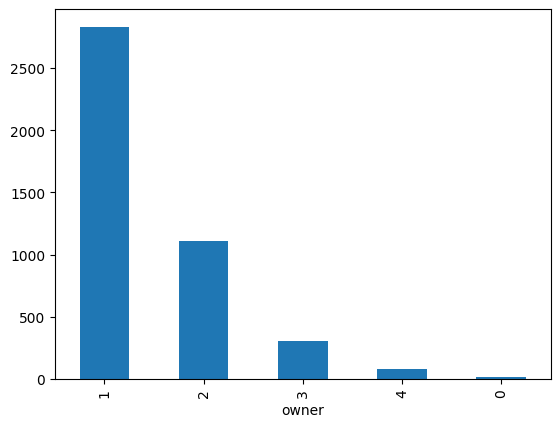

In [89]:
cars.owner.value_counts().plot(kind='bar')
plt.show()

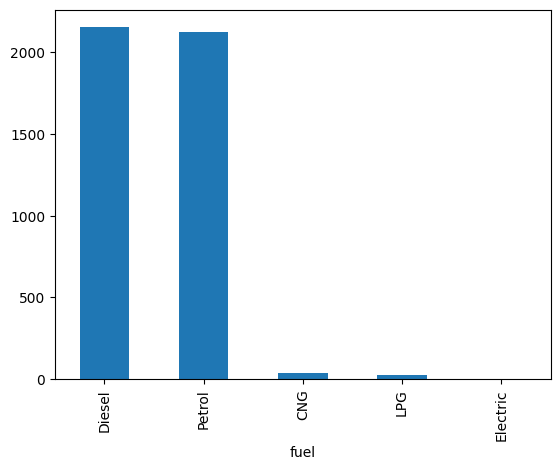

In [90]:
cars.fuel.value_counts().plot(kind='bar')
plt.show()

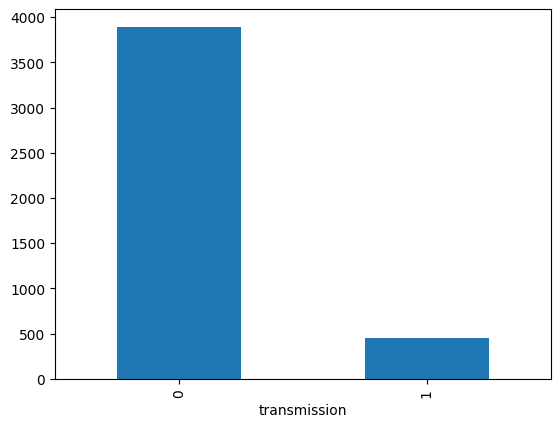

In [91]:
cars.transmission.value_counts().plot(kind='bar')
plt.show()

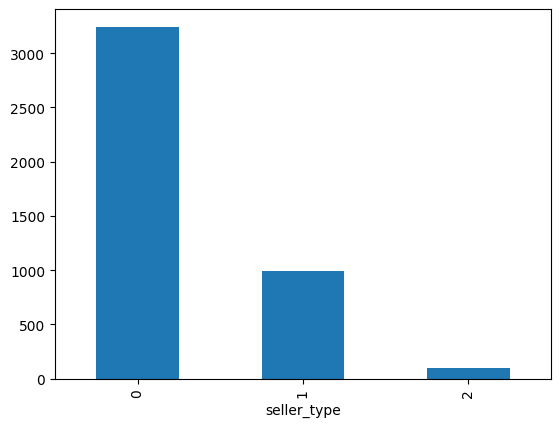

In [92]:
cars.seller_type.value_counts().plot(kind='bar')
plt.show()

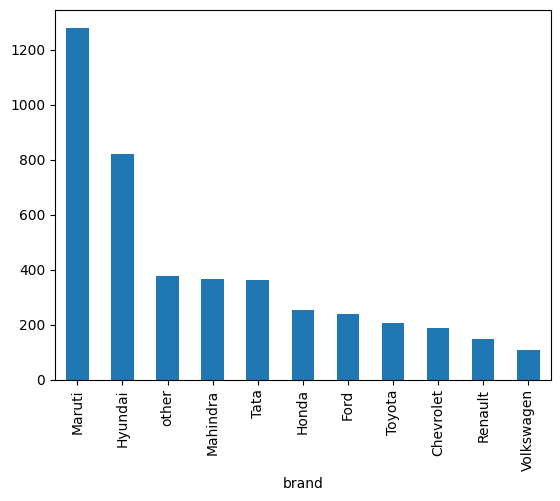

In [88]:
cars.brand.value_counts().plot(kind='bar')
plt.show()

#### BoxPlots

##### By `owner`

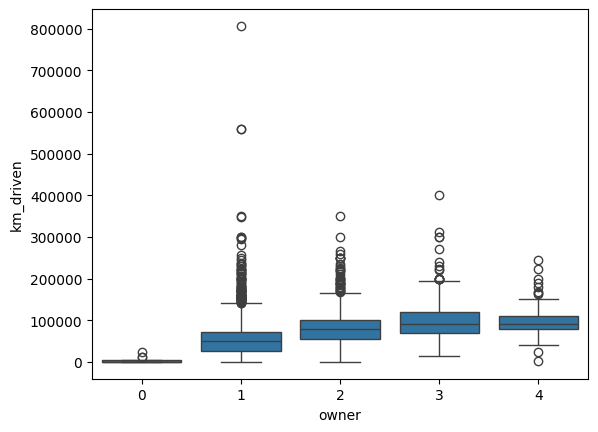

In [94]:
sns.boxplot(cars, x='owner', y='km_driven')
plt.show()

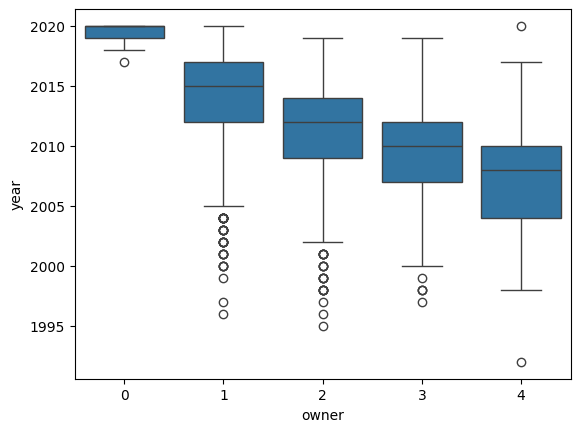

In [95]:
sns.boxplot(cars, x='owner', y='year')
plt.show()

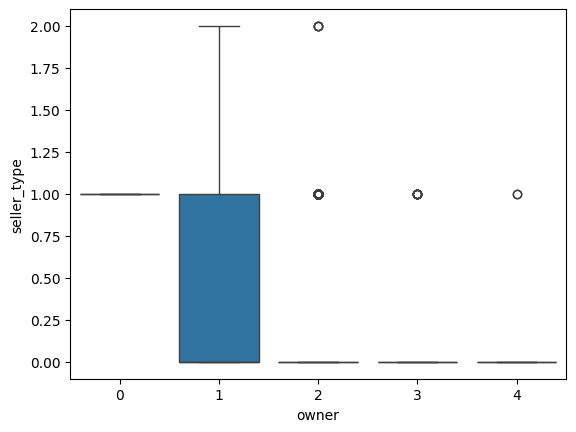

In [100]:
sns.boxplot(cars, x='owner', y='seller_type')
plt.show()

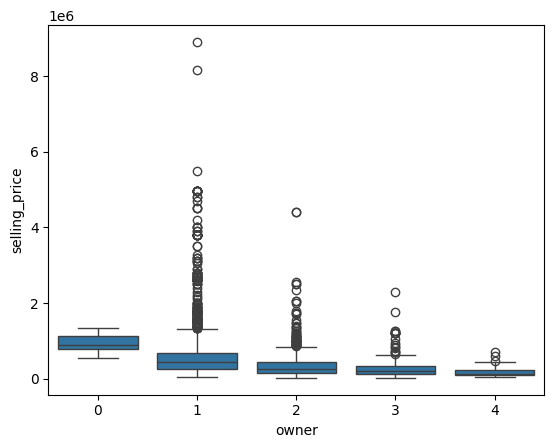

In [108]:
sns.boxplot(cars, x='owner', y='selling_price')
plt.show()

##### By `seller_type`

##### By `transmission`

##### By `fuel`

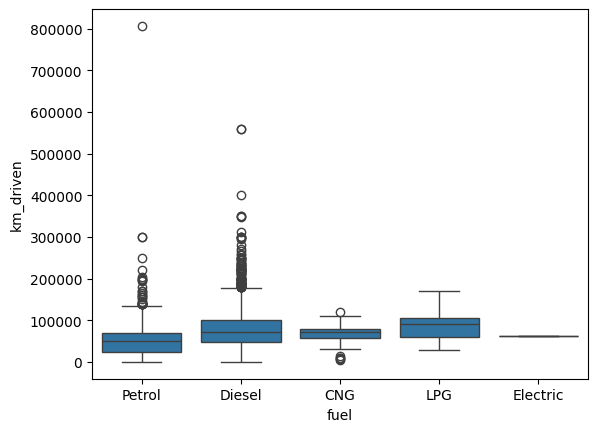

In [103]:
sns.boxplot(cars, x='fuel', y='km_driven')
plt.show()

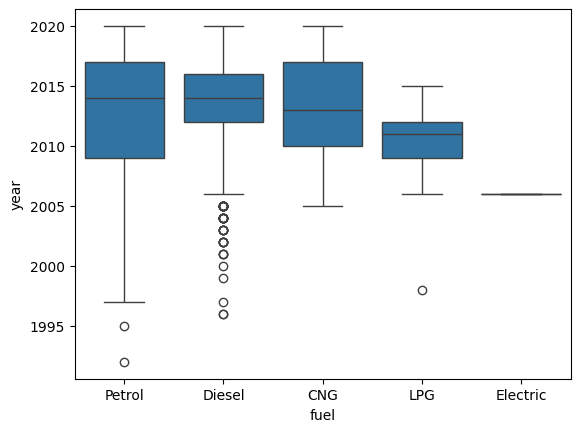

In [104]:
sns.boxplot(cars, x='fuel', y='year')
plt.show()

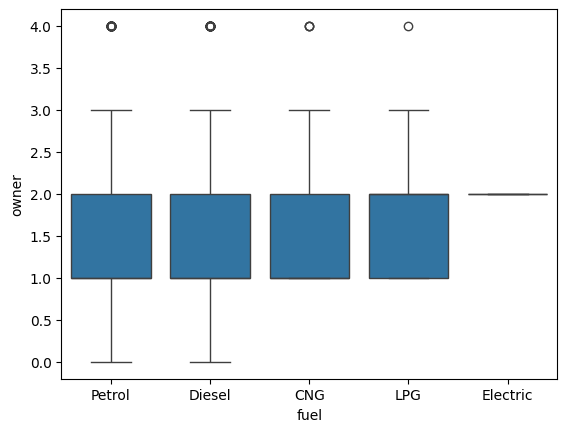

In [105]:
sns.boxplot(cars, x='fuel', y='owner')
plt.show()

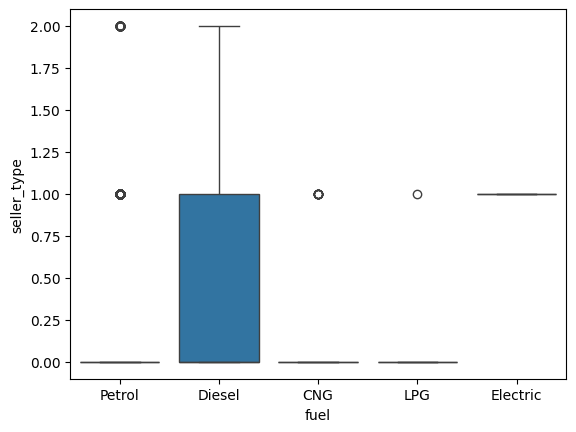

In [107]:
sns.boxplot(cars, x='fuel', y='seller_type')
plt.show()

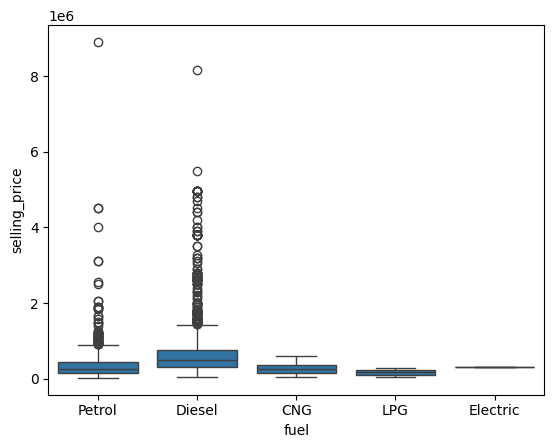

In [109]:
sns.boxplot(cars, x='fuel', y='selling_price')
plt.show()

##### By `brand`

In [98]:
continuousFeatures

['km_driven', 'year']

In [97]:
ordinalFeatures

['owner', 'seller_type', 'transmission']

In [102]:
nominalFeatures

['brand', 'fuel']

In [93]:
cars.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'brand'],
      dtype='object')

## Data Preprocessing

### Data Cleaning

### Data Wrangling

## Feature engineering

In [ ]:
cars['brand'] = cars.name.str.split().str[0]

In [19]:
cars.drop('name', axis=1, inplace=True)

# 3. Model Building

# 4. Evaluation

# 5. Model Deployment

# 6. Monitoring and Maintenance 

In [56]:
ownerDict

{'First Owner': 1,
 'Second Owner': 2,
 'Fourth & Above Owner': 4,
 'Third Owner': 3,
 'Test Drive Car': 0}

In [57]:
sellerDict

{'Individual': 0, 'Dealer': 1, 'Trustmark Dealer': 2}

In [58]:
transmissionDict

{'Manual': 0, 'Automatic': 1}

# Resources

1. [Mind Map](https://360digitmg.com/mindmap/data-science)
2. [Kaggle information about dataset - Car Dekho](https://www.kaggle.com/datasets/akshaydattatraykhare/car-details-dataset)